##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split as trainTestSplitter

####  <font color=SlateBlue>Google Colab</font>

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

####  <font color=SlateBlue>Preprocessing</font>

In [ ]:
#Tokenizing 
import nltk
nltk.download('punkt')

import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
# from torchtext.legacy.data import Field, TabularDataset
from torchtext.data import Field, TabularDataset

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


####  <font color=SlateBlue>Reading .txt File</font>

In [ ]:
import re

####  <font color=SlateBlue>CNN</font> ####

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

####  <font color=SlateBlue>Model Evaluation</font> ####

In [ ]:
from sklearn.metrics import accuracy_score as calcAccScore
from sklearn.metrics import classification_report as reportClassificationResults

##  <font color=MediumSlateBlue>Reading Data and Saving .csv File</font> ##

####  <font color=SlateBlue>Read and save to csv class where the given file is read, the extra not needed parts are excluded and the remaining desirable sentences and their corresponding lable are kept in a csv file.</font> ####

In [ ]:
class ReadAndSaveCSV():
  def __init__(self, filePath):
    self.filePath = filePath

  def readEachLine(self):
    self.fileLines = []
    with open(self.filePath, 'r') as file:
      allLines = file.readlines()
      self.fileLines += [line.strip() for line in allLines if not line=='\n']

  def removeComment(self):
    for line in self.fileLines:
      commentLine = re.search(r"\AComment", line)
      if not commentLine==None:
        self.fileLines.remove(line)
      else:
        continue
  
  def splitLines(self):
    temp = []

    for line in self.fileLines:
      temp.append(line.split('|'))

    self.fileLines = temp

  def separateRelationAndSentence(self):
    self.relations = []
    self.sentences = []

    for lineNum, lineContent in enumerate(self.fileLines,1):
      if (lineNum%2==0):
        self.relations.append(lineContent)
      else:
        self.sentences.append(lineContent)
  
  def setClassIndex(self):
    refDict = {'Cause-Effect':0, 
               'Instrument-Agency':1,
               'Product-Producer':2, 
               'Content-Container':3,
               'Entity-Origin':4, 
               'Entity-Destination':5,
               'Component-Whole':6, 
               'Member-Collection':7,
               'Message-Topic':8, 
               'Other':9
               }
    
    h = np.array(self.relations).shape
    indxRelations = np.zeros((h), dtype=np.int32)

    for key in refDict:
      idx = (np.array(self.relations)==np.array(key))
      validx = (idx==True) 
      indxRelations[validx] = np.array(refDict[key], dtype=np.int32)

    self.relations = indxRelations.tolist()

  def fixRelations(self, desiredLen=None):
    if not desiredLen==None:
      self.relations = self.relations[0:desiredLen]

    temp = ','.join(str(word) for relation in self.relations for word in relation)
    self.relations = re.sub(r'\([^)]*\)', "",temp).split(',')

    self.setClassIndex()
  
  def fixSentences(self, desiredLen=None):
    if not desiredLen==None:
      self.sentences = self.sentences[0:desiredLen]

    temp = []

    for sentence in self.sentences:
      sentence = ''.join(sentence)
      sentence = re.sub('\t','',sentence)
      sentence = sentence.lstrip('0123456789.-')
      sentence = re.sub('<[^>]*>', '', sentence)
      sentence = sentence.replace('"', '')
      temp.append(sentence)

    self.sentences = temp

  def toCSV(self, fileLoc):
    allData = zip(self.sentences, self.relations)
    df = pd.DataFrame(allData, columns=['Sentences', 'Relations'])

    for punc in string.punctuation:
      df['Sentences'] = df.Sentences.str.replace(punc, " ")

    df.to_csv(fileLoc, index=False)  

  
  def performReadAndSave(self, fileLoc, desiredLen=None):
    self.readEachLine()
    self.removeComment()
    self.splitLines()
    self.separateRelationAndSentence()
    self.fixRelations(desiredLen)
    self.fixSentences(desiredLen)
    self.toCSV(fileLoc)


####  <font color=SlateBlue>Reading train file and altering it in the required manner. </font> ####

In [ ]:
TrainFilePath = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/TRAIN_FILE.TXT'

myFileSaver = ReadAndSaveCSV(TrainFilePath)
myFileSaver.performReadAndSave('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File.csv', 7109)

####  <font color=SlateBlue>Reading test file and altering it in the required manner. </font> ####

In [ ]:
TestFilePath = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/TEST_FILE.TXT'

myFileSaver = ReadAndSaveCSV(TestFilePath)
myFileSaver.performReadAndSave('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Test_File.csv')

##  <font color=MediumSlateBlue>Split Train and Validation Datasets</font> ##

####  <font color=SlateBlue>Splitting the train dataset into train and validation datasets. About 20% of train dataset is introduced as validation dataset. </font> ####

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File.csv')
trainDF, validDF = trainTestSplitter(df, test_size=0.2, random_state=42)
trainDF.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File.csv', index=False)
validDF.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Validation_File.csv', index=False)

##  <font color=MediumSlateBlue>Building Vocabulary</font> ##

####  <font color=SlateBlue>Vocabulary class which calculates the tokenized represetation of sentences</font> ####

In [ ]:
class Vocabulary():
  def __init__(self, minFreq):
    self.minFreq = minFreq

    self.vocabs = Field(sequential=True, 
                        use_vocab=True, 
                        init_token = '<sos>', 
                        eos_token = '<eos>',
                        tokenize=self.tokenizer, 
                        lower=True)

  def __len__(self): return len(self.vocabs.vocab.stoi)

  def tokenizer(self, text): return nltk.word_tokenize(text)

  def buildVocabulary(self, dataPath, format):
    fields = {'Sentences': ('s', self.vocabs)}
    dataset = TabularDataset(path=dataPath, format=format, 
                             fields=fields)
    
    self.vocabs.build_vocab(dataset, max_size=10000, min_freq=self.minFreq)

  def numericalize(self, text):
    tokenizedText = self.tokenizer(text)

    return [
        self.vocabs.vocab.stoi[token] 
        if token in self.vocabs.vocab.stoi 
        else self.vocabs.vocab.stoi['<unk>']
        for token in tokenizedText
        ]

####  <font color=SlateBlue>MyCollate is a class responsible for padding. </font> ####

In [ ]:
class MyCollate():
  def __init__(self, padIndx):
    self.padIndx = padIndx

  def __call__(self, batch):
    relations = torch.cat([item[1] for item in batch], dim=0)

    sentences = [item[0] for item in batch]
    sentences = pad_sequence(sentences, 
                           batch_first=False, 
                           padding_value=self.padIndx)

    return sentences, relations

####  <font color=SlateBlue>SemEvalTaskDataset is a class which reads all sentences and their corresponding relation.</font> ####

In [ ]:
class SemEvalTaskDataset(Dataset):
  def __init__(self, fileLoc, sentenceVocab, mode='Train'):
    
    self.df = pd.read_csv(fileLoc)

    self.sentences = self.df['Sentences']
    self.relations = self.df['Relations']

    self.sentenceVocab = sentenceVocab

    if mode == 'Train':
      self.sentenceVocab.buildVocabulary(
          dataPath=fileLoc, 
          format='csv'
          )

  def __len__(self): return len(self.df)

  def getBuiltVocab(self): return self.sentenceVocab

  def __getitem__(self, indx):
    relation = self.relations[indx]

    sentence = self.sentences[indx]
    numericalizedSentence = [self.sentenceVocab.vocabs.vocab.stoi['<sos>']]
    numericalizedSentence.extend(self.sentenceVocab.numericalize(sentence))
    numericalizedSentence.append(self.sentenceVocab.vocabs.vocab.stoi['<eos>'])
  
    return torch.tensor(numericalizedSentence), torch.tensor([relation])

####  <font color=SlateBlue>Getloader is a function returning a dataloader as well as the created dataset based on the given data</font> ####

In [ ]:
def getLoader(fileLoc, 
              sentenceVocab,  
              mode, 
              batchSize=256, 
              numWorkers=0, 
              shuffle=True, 
              pinMemory=True):
  
  dataset = SemEvalTaskDataset(fileLoc, sentenceVocab, mode)

  padIndx = (dataset.getBuiltVocab()).vocabs.vocab.stoi['<pad>']

  loader = DataLoader(dataset=dataset,
                      batch_size=batchSize,
                      num_workers=numWorkers,
                      shuffle=shuffle,
                      pin_memory=pinMemory,
                      collate_fn=MyCollate(padIndx=padIndx))

  return loader, dataset

####  <font color=SlateBlue>Creating train dataloader and dataset.</font> ####

In [ ]:
trainDataLoader, trainDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File.csv',
    fileLoc='../input/my-semeval2010-task-8/Train_File.csv',
    sentenceVocab=Vocabulary(5),
    mode='Train',
    batchSize=8,
    numWorkers=2)

####  <font color=SlateBlue>Creating validation dataloader and dataset.</font> ####

In [ ]:
validDataLoader, validDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Validation_File.csv',
    fileLoc='../input/my-semeval2010-task-8/Validation_File.csv',
    sentenceVocab=trainDataset.getBuiltVocab(),
    mode='Valid',
    batchSize=8,
    numWorkers=2)

####  <font color=SlateBlue>Creating test dataloader and dataset.</font> ####

In [ ]:
testDataLoader, testDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Test_File.csv',
    fileLoc='../input/my-semeval2010-task-8/Test_File.csv',
    sentenceVocab=trainDataset.getBuiltVocab(),
    mode='Test',
    batchSize=1,
    numWorkers=2)

##  <font color=MediumSlateBlue>Creating the Neural Network.</font> ##

In [ ]:
class RENeuralNetwork(nn.Module):
  def __init__(self, 
               vocabSize, 
               embedSize=100,
               hiddenSize=150,
               numLayers=2, 
               LSTMDropout=0, 
               dropoutP=0.7,
               numClass=10):
    super(RENeuralNetwork, self).__init__()
    
    self.embed = nn.Embedding(num_embeddings=vocabSize, 
                              embedding_dim=embedSize)
    
    self.lstm = nn.LSTM(input_size=embedSize, 
                        hidden_size=hiddenSize, 
                        num_layers=numLayers,
                        dropout=LSTMDropout,
                        bidirectional=True)
    
    self.linear = nn.Linear(in_features=2*hiddenSize, 
                            out_features=numClass)
    
    self.dropout = nn.Dropout(p=dropoutP)

    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, inputSentence, concatIndexes=[-2, -1]):
    embedSentence =  self.dropout(self.embed(inputSentence))
    output, (h_n, c_n) = self.lstm(embedSentence)
    output = torch.cat((h_n[concatIndexes[0], :, :], 
                        h_n[concatIndexes[1], :, :]), 
                       dim=1
                       )
    output = self.linear(output)
    return self.softmax(output)

##  <font color=MediumSlateBlue>Training the Neural Network.</font> #

In [ ]:
def train(trainDataLoader, trainDataset,
          validDataLoader, testDataLoader,
          embedSize=100, hiddenSize=150,
          numLayers=2, LSTMDropout=0.5,
          dropoutP=0.7, numEpochs=30,
          freezeState=True):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  datasetVocab = (trainDataset.getBuiltVocab()).vocabs.vocab

  #Hyperparameters
  vocabSize = len(datasetVocab)
  learningRate = 3e-4

  #Model creation
  model = RENeuralNetwork(vocabSize=vocabSize,
                          embedSize=embedSize,
                          hiddenSize=hiddenSize,
                          numLayers=numLayers,
                          LSTMDropout=LSTMDropout,
                          dropoutP=dropoutP,
                          numClass=10).to(device)

  criterion = nn.NLLLoss(ignore_index=datasetVocab.stoi['<pad>'])
  optimizer = optim.Adam(model.parameters(), lr=learningRate)

  allEpochTrainLoss, allEpochValidLoss = [], []
  trainAcc, validAcc = [], []

  for numEpoch in range(numEpochs):
    print('Epoch %d has started......' %(numEpoch+1))
    oneEpochTrainLoss, oneEpochValidLoss = 0, 0
    oneEpochTrainAcc, oneEpochValidAcc = [], []

    print('Training the network......')
    model.train()

    for iteration, (sentences, labels) in enumerate(trainDataLoader):
      sentences = sentences.to(device)
      labels = labels.to(device)

      outputs = model(sentences)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      oneEpochTrainLoss += loss.item()

      outputs = outputs.max(dim=1)[1]
      oneEpochTrainAcc.append(calcAccScore(labels.data.cpu().detach().numpy(), outputs.data.cpu().detach().numpy()))

      #Printing training loss every 70 iterations
      if (iteration+1)%70==0: 
        print('Iteration:%d \t Loss:%1.5f' %(iteration+1, oneEpochTrainLoss/(iteration+1)))

    #Printing training loss and accuracy at the end of each epoch
    print('At the end of epoch %d:' %(numEpoch+1))
    print('The average training loss is: %1.5f' %(oneEpochTrainLoss/len(trainDataLoader)))
    print('The accuracy on training data is: %1.5f' %(sum(oneEpochTrainAcc)/len(oneEpochTrainAcc)))

    allEpochTrainLoss.append(oneEpochTrainLoss/len(trainDataLoader))
    trainAcc.append(sum(oneEpochTrainAcc)/len(oneEpochTrainAcc))

    #Plotting training loss and accuracy in every 10 epochs
    if (numEpoch+1)%10==0:
      plt.plot(allEpochTrainLoss, label='Training Loss', color='slateblue')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

      plt.plot(trainAcc, label='Training Accuracy', color='slateblue')
      plt.title('Accuracy vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Accuracy')
      plt.legend(loc='best')
      plt.show()

    print('...............................................')
    print('Validating the network......')
    model.eval()

    with torch.no_grad():
      for iteration, (sentences, labels) in enumerate(validDataLoader):
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        loss = criterion(outputs, labels)
  
        oneEpochValidLoss += loss.item()

        outputs = outputs.max(dim=1)[1]
        oneEpochValidAcc.append(calcAccScore(labels.data.cpu().detach().numpy(), outputs.data.cpu().detach().numpy()))

        #Printing validation loss every 20 iterations
        if (iteration+1)%20==0:
          print('Iteration:%d \t Loss:%1.5f' %(iteration+1, oneEpochValidLoss/(iteration+1)))

    #Printing validation loss and accuracy at the end of each epoch
    print('At the end of epoch %d:' %(numEpoch+1))
    print('The average validation loss is: %1.5f' %(oneEpochValidLoss/len(validDataLoader)))
    print('The accuracy on validation data is: %1.5f' %(sum(oneEpochValidAcc)/len(oneEpochValidAcc)))

    allEpochValidLoss.append(oneEpochValidLoss/len(validDataLoader))
    validAcc.append(sum(oneEpochValidAcc)/len(oneEpochValidAcc))

    #Plotting validation loss and accuracy in every 10 epochs
    if (numEpoch+1)%10==0:
      plt.plot(allEpochValidLoss, label='Validation Loss', color='mediumpurple')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

      plt.plot(validAcc, label='Validation Accuracy', color='mediumpurple')
      plt.title('Accuracy vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Accuracy')
      plt.legend(loc='best')
      plt.show()      

    print('********************************************************')

  plt.plot(allEpochTrainLoss, label='Training Loss', color='slateblue')
  plt.plot(allEpochValidLoss, label='Validation Loss', color='mediumpurple')
  plt.title('Loss vs. Epochs')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  plt.show() 

  plt.plot(trainAcc, label='Training Accuracy', color='slateblue')
  plt.plot(validAcc, label='Validation Accuracy', color='mediumpurple')
  plt.title('Accuracy vs. Epochs')
  plt.xlabel('Number of Epochs Untill Now')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show() 

  with torch.no_grad():
    allLabels, allOutputs = [], []
    for sentences, labels in testDataLoader:
      sentences = sentences.to(device)
      outputs = model(sentences)
      outputs = outputs.max(dim=1)[1]

      allLabels.append(labels.data.cpu().numpy())
      allOutputs.append(outputs.data.cpu().numpy())



  print(reportClassificationResults(allLabels, allOutputs, zero_division=0))

Epoch 1 has started......
Training the network......
Iteration:70 	 Loss:2.24422
Iteration:140 	 Loss:2.20094
Iteration:210 	 Loss:2.18663
Iteration:280 	 Loss:2.16929
Iteration:350 	 Loss:2.15322
Iteration:420 	 Loss:2.14357
Iteration:490 	 Loss:2.13336
Iteration:560 	 Loss:2.12415
Iteration:630 	 Loss:2.11020
Iteration:700 	 Loss:2.09958
At the end of epoch 1:
The average training loss is: 2.09910
The accuracy on training data is: 0.18462
...............................................
Validating the network......
Iteration:20 	 Loss:1.87261
Iteration:40 	 Loss:1.82925
Iteration:60 	 Loss:1.83779
Iteration:80 	 Loss:1.85264
Iteration:100 	 Loss:1.86144
Iteration:120 	 Loss:1.87779
Iteration:140 	 Loss:1.88698
Iteration:160 	 Loss:1.88306
At the end of epoch 1:
The average validation loss is: 1.89796
The accuracy on validation data is: 0.25726
********************************************************
Epoch 2 has started......
Training the network......
Iteration:70 	 Loss:1.90133
Itera

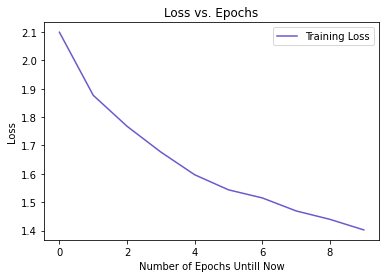

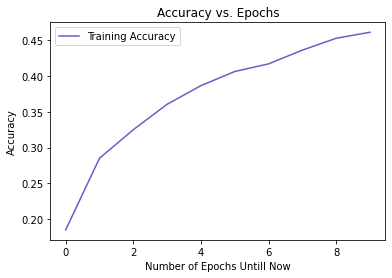

...............................................
Validating the network......
Iteration:20 	 Loss:1.31355
Iteration:40 	 Loss:1.35883
Iteration:60 	 Loss:1.39775
Iteration:80 	 Loss:1.41403
Iteration:100 	 Loss:1.42852
Iteration:120 	 Loss:1.41977
Iteration:140 	 Loss:1.40006
Iteration:160 	 Loss:1.41359
At the end of epoch 10:
The average validation loss is: 1.42308
The accuracy on validation data is: 0.45927


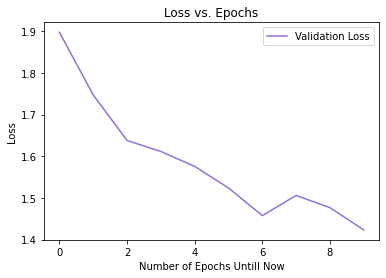

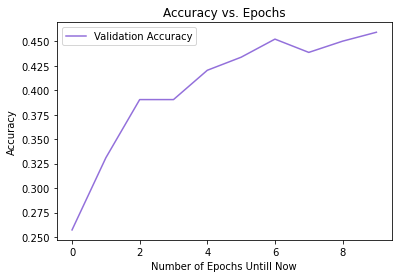

********************************************************
Epoch 11 has started......
Training the network......
Iteration:70 	 Loss:1.39684
Iteration:140 	 Loss:1.36830
Iteration:210 	 Loss:1.37800
Iteration:280 	 Loss:1.37794
Iteration:350 	 Loss:1.37533
Iteration:420 	 Loss:1.37179
Iteration:490 	 Loss:1.36616
Iteration:560 	 Loss:1.37183
Iteration:630 	 Loss:1.38120
Iteration:700 	 Loss:1.38508
At the end of epoch 11:
The average training loss is: 1.38579
The accuracy on training data is: 0.46913
...............................................
Validating the network......
Iteration:20 	 Loss:1.63703
Iteration:40 	 Loss:1.50857
Iteration:60 	 Loss:1.44741
Iteration:80 	 Loss:1.43801
Iteration:100 	 Loss:1.44625
Iteration:120 	 Loss:1.45193
Iteration:140 	 Loss:1.44453
Iteration:160 	 Loss:1.43077
At the end of epoch 11:
The average validation loss is: 1.43427
The accuracy on validation data is: 0.46559
********************************************************
Epoch 12 has started......

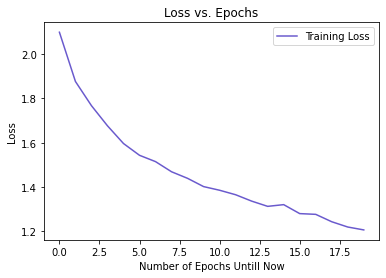

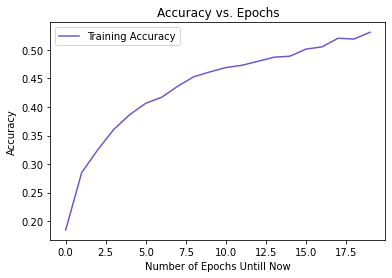

...............................................
Validating the network......
Iteration:20 	 Loss:1.43147
Iteration:40 	 Loss:1.38768
Iteration:60 	 Loss:1.38403
Iteration:80 	 Loss:1.42381
Iteration:100 	 Loss:1.37326
Iteration:120 	 Loss:1.39738
Iteration:140 	 Loss:1.34045
Iteration:160 	 Loss:1.36070
At the end of epoch 20:
The average validation loss is: 1.35123
The accuracy on validation data is: 0.50609


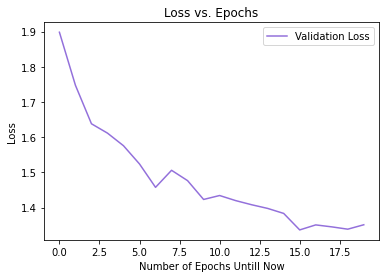

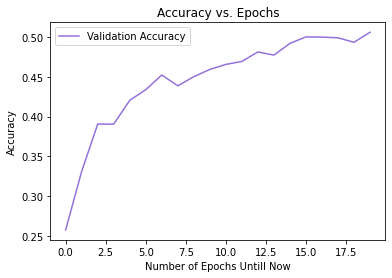

********************************************************
Epoch 21 has started......
Training the network......
Iteration:70 	 Loss:1.18215
Iteration:140 	 Loss:1.17598
Iteration:210 	 Loss:1.16906
Iteration:280 	 Loss:1.16538
Iteration:350 	 Loss:1.16872
Iteration:420 	 Loss:1.17549
Iteration:490 	 Loss:1.18517
Iteration:560 	 Loss:1.18540
Iteration:630 	 Loss:1.18750
Iteration:700 	 Loss:1.19396
At the end of epoch 21:
The average training loss is: 1.19456
The accuracy on training data is: 0.53057
...............................................
Validating the network......
Iteration:20 	 Loss:1.17044
Iteration:40 	 Loss:1.35999
Iteration:60 	 Loss:1.42231
Iteration:80 	 Loss:1.42660
Iteration:100 	 Loss:1.40883
Iteration:120 	 Loss:1.41472
Iteration:140 	 Loss:1.40162
Iteration:160 	 Loss:1.37830
At the end of epoch 21:
The average validation loss is: 1.36672
The accuracy on validation data is: 0.50632
********************************************************
Epoch 22 has started......

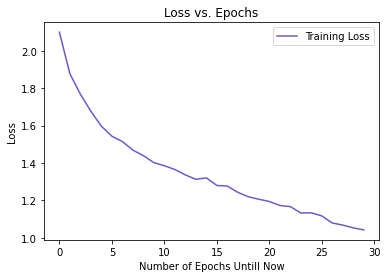

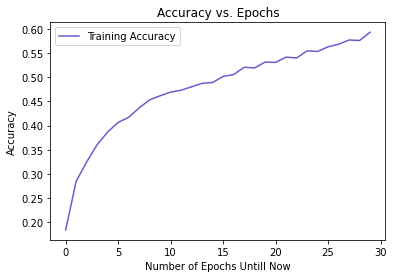

...............................................
Validating the network......
Iteration:20 	 Loss:1.34975
Iteration:40 	 Loss:1.38008
Iteration:60 	 Loss:1.35028
Iteration:80 	 Loss:1.34263
Iteration:100 	 Loss:1.33826
Iteration:120 	 Loss:1.34378
Iteration:140 	 Loss:1.34571
Iteration:160 	 Loss:1.31755
At the end of epoch 30:
The average validation loss is: 1.32213
The accuracy on validation data is: 0.53301


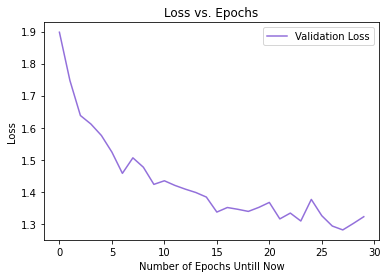

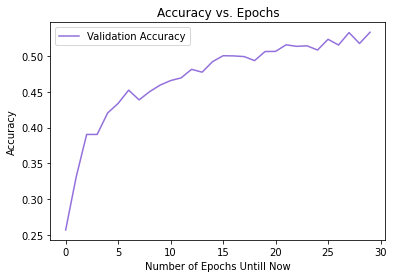

********************************************************
Epoch 31 has started......
Training the network......
Iteration:70 	 Loss:1.04793
Iteration:140 	 Loss:1.05305
Iteration:210 	 Loss:1.04200
Iteration:280 	 Loss:1.02803
Iteration:350 	 Loss:1.03872
Iteration:420 	 Loss:1.02961
Iteration:490 	 Loss:1.03729
Iteration:560 	 Loss:1.03884
Iteration:630 	 Loss:1.03156
Iteration:700 	 Loss:1.02990
At the end of epoch 31:
The average training loss is: 1.03062
The accuracy on training data is: 0.58785
...............................................
Validating the network......
Iteration:20 	 Loss:1.17186
Iteration:40 	 Loss:1.19185
Iteration:60 	 Loss:1.16964
Iteration:80 	 Loss:1.23475
Iteration:100 	 Loss:1.25055
Iteration:120 	 Loss:1.23033
Iteration:140 	 Loss:1.22352
Iteration:160 	 Loss:1.23876
At the end of epoch 31:
The average validation loss is: 1.26997
The accuracy on validation data is: 0.53301
********************************************************
Epoch 32 has started......

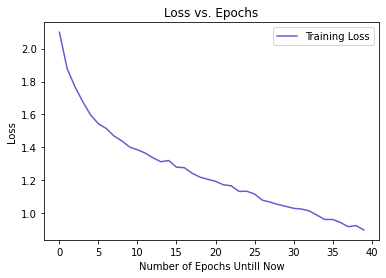

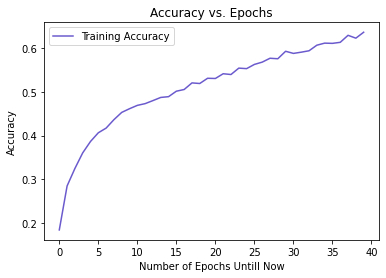

...............................................
Validating the network......
Iteration:20 	 Loss:1.29339
Iteration:40 	 Loss:1.35019
Iteration:60 	 Loss:1.37285
Iteration:80 	 Loss:1.35074
Iteration:100 	 Loss:1.37347
Iteration:120 	 Loss:1.36520
Iteration:140 	 Loss:1.35717
Iteration:160 	 Loss:1.33050
At the end of epoch 40:
The average validation loss is: 1.34674
The accuracy on validation data is: 0.54869


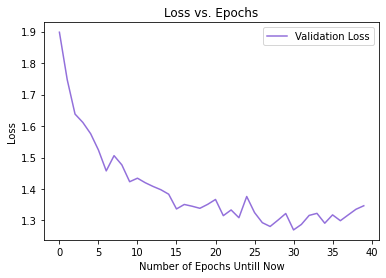

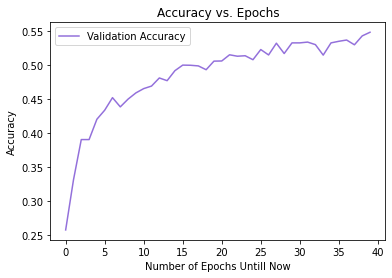

********************************************************
Epoch 41 has started......
Training the network......
Iteration:70 	 Loss:0.92055
Iteration:140 	 Loss:0.90420
Iteration:210 	 Loss:0.87654
Iteration:280 	 Loss:0.89505
Iteration:350 	 Loss:0.89768
Iteration:420 	 Loss:0.88601
Iteration:490 	 Loss:0.88190
Iteration:560 	 Loss:0.87867
Iteration:630 	 Loss:0.87496
Iteration:700 	 Loss:0.86599
At the end of epoch 41:
The average training loss is: 0.86561
The accuracy on training data is: 0.64570
...............................................
Validating the network......
Iteration:20 	 Loss:1.33207
Iteration:40 	 Loss:1.24207
Iteration:60 	 Loss:1.33222
Iteration:80 	 Loss:1.34411
Iteration:100 	 Loss:1.31979
Iteration:120 	 Loss:1.36978
Iteration:140 	 Loss:1.37210
Iteration:160 	 Loss:1.36113
At the end of epoch 41:
The average validation loss is: 1.35405
The accuracy on validation data is: 0.54448
********************************************************
Epoch 42 has started......

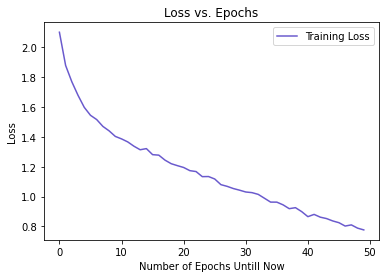

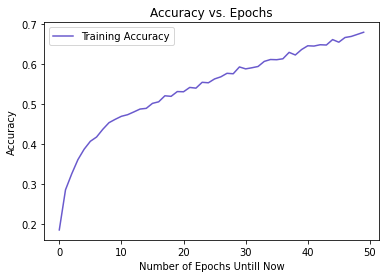

...............................................
Validating the network......
Iteration:20 	 Loss:1.32784
Iteration:40 	 Loss:1.51686
Iteration:60 	 Loss:1.44758
Iteration:80 	 Loss:1.40198
Iteration:100 	 Loss:1.43140
Iteration:120 	 Loss:1.37069
Iteration:140 	 Loss:1.37131
Iteration:160 	 Loss:1.40079
At the end of epoch 50:
The average validation loss is: 1.38476
The accuracy on validation data is: 0.54354


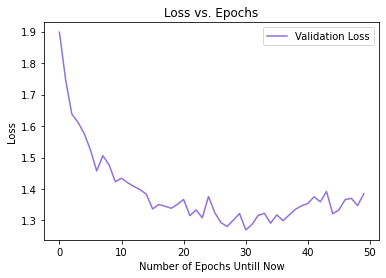

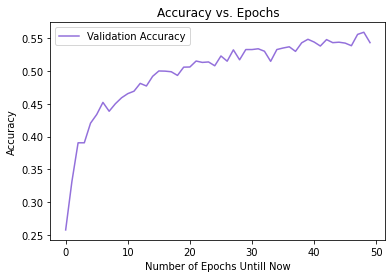

********************************************************
Epoch 51 has started......
Training the network......
Iteration:70 	 Loss:0.72376
Iteration:140 	 Loss:0.69069
Iteration:210 	 Loss:0.75043
Iteration:280 	 Loss:0.73510
Iteration:350 	 Loss:0.74665
Iteration:420 	 Loss:0.75113
Iteration:490 	 Loss:0.74593
Iteration:560 	 Loss:0.75392
Iteration:630 	 Loss:0.76006
Iteration:700 	 Loss:0.76397
At the end of epoch 51:
The average training loss is: 0.76342
The accuracy on training data is: 0.68194
...............................................
Validating the network......
Iteration:20 	 Loss:1.34879
Iteration:40 	 Loss:1.37301
Iteration:60 	 Loss:1.43380
Iteration:80 	 Loss:1.39050
Iteration:100 	 Loss:1.34120
Iteration:120 	 Loss:1.40182
Iteration:140 	 Loss:1.40265
Iteration:160 	 Loss:1.40602
At the end of epoch 51:
The average validation loss is: 1.40842
The accuracy on validation data is: 0.53933
********************************************************
Epoch 52 has started......

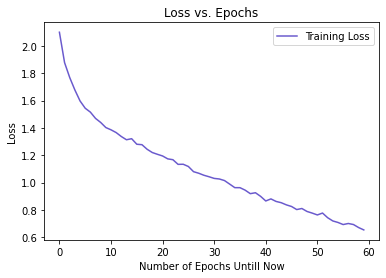

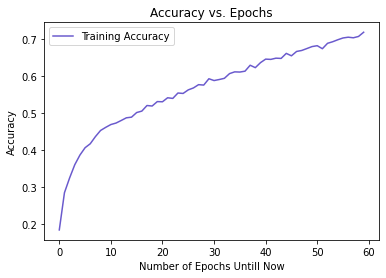

...............................................
Validating the network......
Iteration:20 	 Loss:1.41968
Iteration:40 	 Loss:1.51804
Iteration:60 	 Loss:1.53066
Iteration:80 	 Loss:1.48701
Iteration:100 	 Loss:1.44742
Iteration:120 	 Loss:1.48645
Iteration:140 	 Loss:1.52339
Iteration:160 	 Loss:1.47407
At the end of epoch 60:
The average validation loss is: 1.44170
The accuracy on validation data is: 0.55829


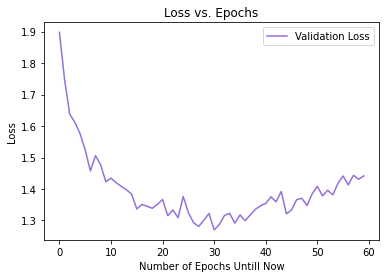

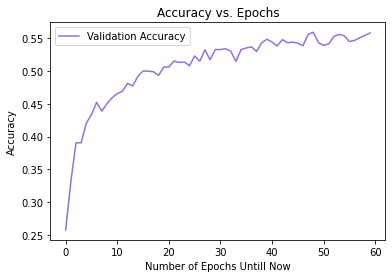

********************************************************
Epoch 61 has started......
Training the network......
Iteration:70 	 Loss:0.67562
Iteration:140 	 Loss:0.65821
Iteration:210 	 Loss:0.64762
Iteration:280 	 Loss:0.65241
Iteration:350 	 Loss:0.65364
Iteration:420 	 Loss:0.65832
Iteration:490 	 Loss:0.65641
Iteration:560 	 Loss:0.64804
Iteration:630 	 Loss:0.64649
Iteration:700 	 Loss:0.64312
At the end of epoch 61:
The average training loss is: 0.64436
The accuracy on training data is: 0.72463
...............................................
Validating the network......
Iteration:20 	 Loss:1.38026
Iteration:40 	 Loss:1.37325
Iteration:60 	 Loss:1.44410
Iteration:80 	 Loss:1.45243
Iteration:100 	 Loss:1.42488
Iteration:120 	 Loss:1.47607
Iteration:140 	 Loss:1.47580
Iteration:160 	 Loss:1.48890
At the end of epoch 61:
The average validation loss is: 1.47703
The accuracy on validation data is: 0.54869
********************************************************
Epoch 62 has started......

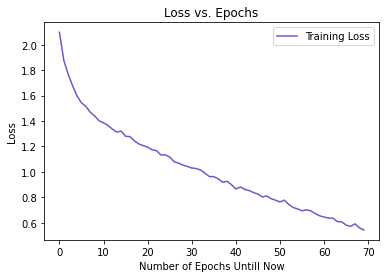

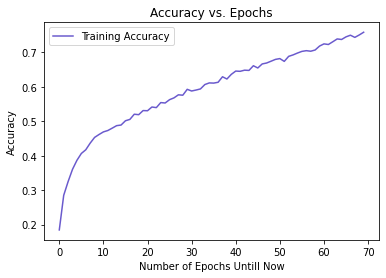

...............................................
Validating the network......
Iteration:20 	 Loss:1.41467
Iteration:40 	 Loss:1.65776
Iteration:60 	 Loss:1.61836
Iteration:80 	 Loss:1.54153
Iteration:100 	 Loss:1.50488
Iteration:120 	 Loss:1.49886
Iteration:140 	 Loss:1.49644
Iteration:160 	 Loss:1.49048
At the end of epoch 70:
The average validation loss is: 1.49770
The accuracy on validation data is: 0.54658


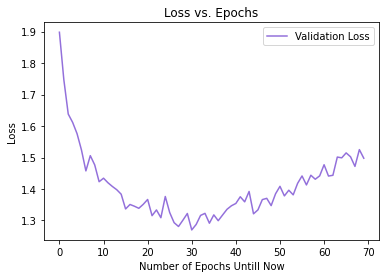

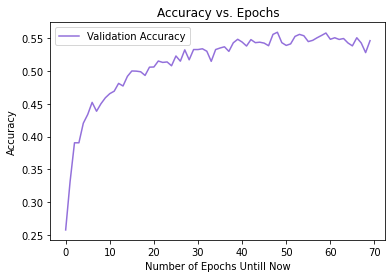

********************************************************


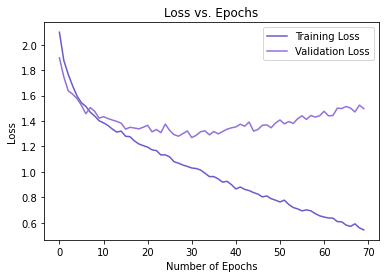

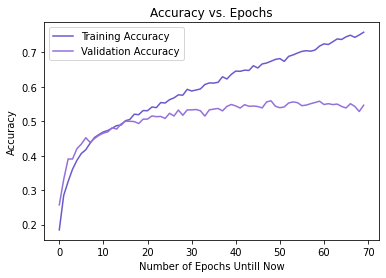

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       328
           1       0.00      0.00      0.00       156
           2       0.48      0.32      0.38       231
           3       0.71      0.84      0.77       192
           4       0.64      0.57      0.61       258
           5       0.71      0.90      0.80       292
           6       0.45      0.50      0.47       312
           7       0.40      0.73      0.52       233
           8       0.46      0.50      0.48       261
           9       0.32      0.23      0.27       454

    accuracy                           0.54      2717
   macro avg       0.49      0.54      0.51      2717
weighted avg       0.50      0.54      0.51      2717



In [ ]:
train(trainDataLoader, trainDataset,
      validDataLoader, testDataLoader,
      embedSize=100, hiddenSize=150,
      numLayers=2, LSTMDropout=0.5,
      dropoutP=0.7, numEpochs=70)